In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import scipy.stats as stats
from tabulate import tabulate
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
import joblib

warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/kaggle/input/crop-csv/crop.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [5]:
df.shape


(2200, 8)

In [4]:
distinct_labels = df['label'].unique()

# Display the distinct labels
distinct_labels

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

The suitable crops for Tunisia:
maize,kidneybeans,chickpea,lentil,pomegranate,grapes,watermelon,muskmelon,apple,orange and cotton

In [15]:
# List of desired crop labels
desired_labels = ['maize', 'chickpea', 'lentil', 'pomegranate','kidneybeans', 'grapes', 'watermelon', 'muskmelon', 'apple', 'orange', 'cotton']

# Filter the dataframe to only include rows with those labels
filtered_df = df[df['label'].isin(desired_labels)]

# Display the filtered dataframe
filtered_df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
100,71,54,16,22.613600,63.690706,5.749914,87.759539,maize
101,61,44,17,26.100184,71.574769,6.931757,102.266244,maize
102,80,43,16,23.558821,71.593514,6.657965,66.719955,maize
103,73,58,21,19.972160,57.682729,6.596061,60.651715,maize
104,61,38,20,18.478913,62.695039,5.970458,65.438354,maize


In [30]:
# Display basic information about the dataset
print("Basic Info:")
print(filtered_df.info())  # Shows data types, non-null count, memory usage

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(filtered_df.describe())  # Summary statistics for numerical features

# Check for missing values
print("\nMissing Values:")
print(filtered_df.isnull().sum())  # Count of missing values per column

# Check for duplicate rows in the dataframe
duplicates = filtered_df.duplicated()

# Display the count of duplicate rows
print(f"\nNumber of duplicate rows: {duplicates.sum()}")

# Optionally, display the duplicate rows
print("\nDuplicate Rows:")
print(filtered_df[duplicates])

# Check the distribution of labels (crop types)
print("\nLabel Distribution:")
print(filtered_df['label'].value_counts())  # Distribution of crop labels

# Check the unique values of categorical columns
print("\nUnique Values in Categorical Columns:")
for col in filtered_df.select_dtypes(include=['object']).columns:
    print(f"{col}: {filtered_df[col].unique()}")  # Display unique values for categorical columns

Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1100 entries, 100 to 1999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            1100 non-null   int64  
 1   P            1100 non-null   int64  
 2   K            1100 non-null   int64  
 3   temperature  1100 non-null   float64
 4   humidity     1100 non-null   float64
 5   ph           1100 non-null   float64
 6   rainfall     1100 non-null   float64
 7   label        1100 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 77.3+ KB
None

Summary Statistics:
                 N            P            K  temperature     humidity           ph     rainfall
count  1100.000000  1100.000000  1100.000000  1100.000000  1100.000000  1100.000000  1100.000000
mean     50.664545    57.740000    64.477273    23.201278    71.110346     6.493498    79.324585
std      39.685332    41.661551    66.816839     4.780450    26.374240     0.667461  

In [31]:
# Group by 'label' and calculate the min and max values for each numerical column
label_groups = filtered_df.groupby('label')[numerical_cols].agg(['min', 'max'])

# Display the min and max values for each label and numerical feature
print("Min and Max Values for Each Label:")
print(label_groups)


Min and Max Values for Each Label:
               N         P         K      temperature              humidity                   ph              rainfall            
             min  max  min  max  min  max         min        max        min        max       min       max         min         max
label                                                                                                                             
apple          0   40  120  145  195  205   21.036527  23.996862  90.025751  94.920481  5.514253  6.499227  100.117344  124.983162
chickpea      20   60   55   80   75   85   17.024985  20.995022  14.258040  19.969789  5.988993  8.868741   65.113656   94.781896
cotton       100  140   35   60   15   25   22.000851  25.992374  75.005393  84.876690  5.801048  7.994680   60.653817   99.931008
grapes         0   40  120  145  195  205    8.825675  41.948657  80.016394  83.983517  5.510925  6.499605   65.010953   74.915062
kidneybeans    0   40   55   80   15   25   15.3

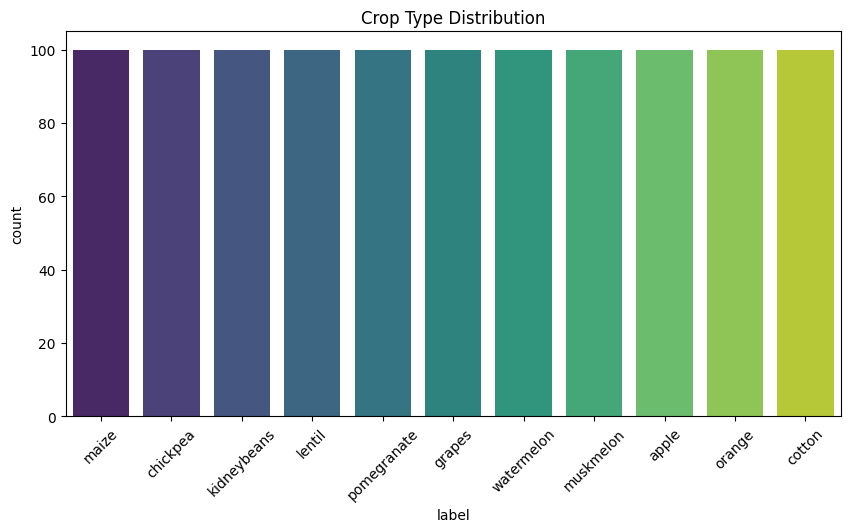

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=filtered_df, order=filtered_df['label'].value_counts().index, palette='viridis')
plt.xticks(rotation=45)
plt.title('Crop Type Distribution')
plt.show()


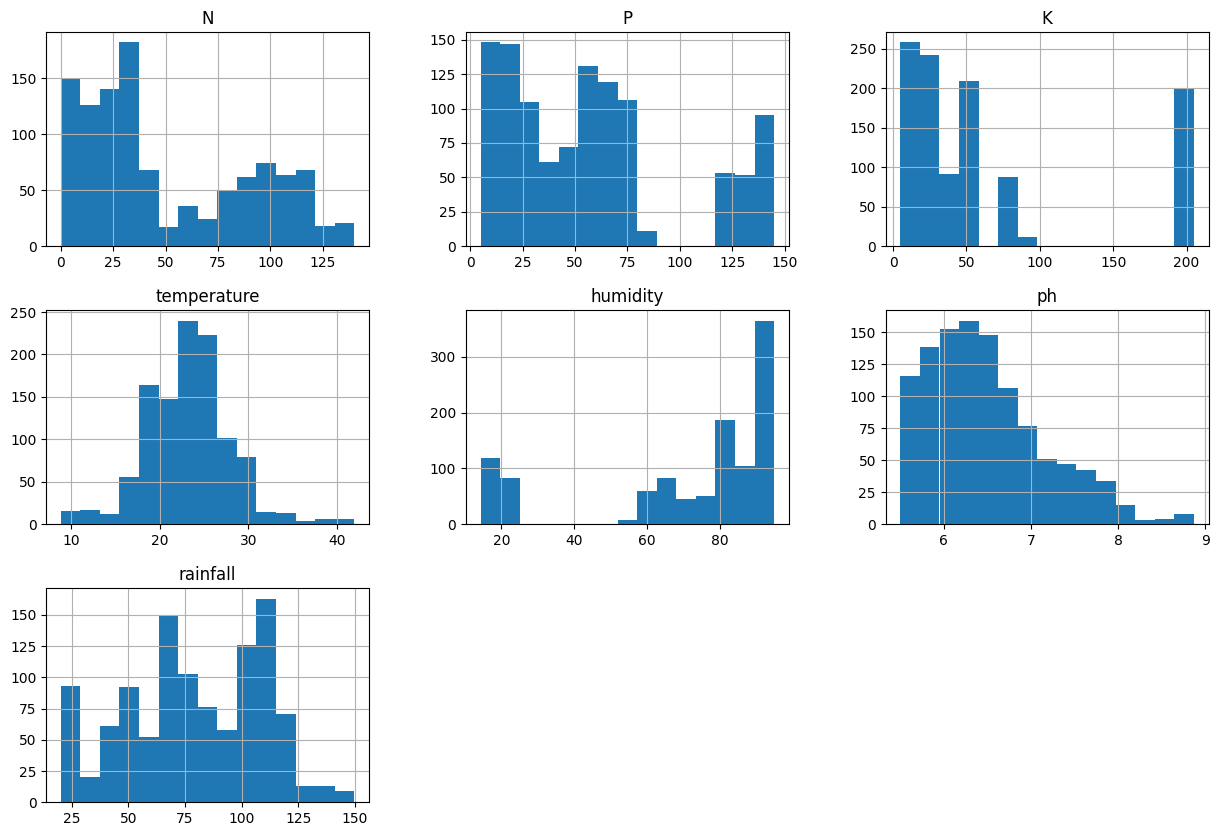

In [17]:
# Histograms for the numerical cols
filtered_df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']].hist(bins=15, figsize=(15, 10))
plt.show()

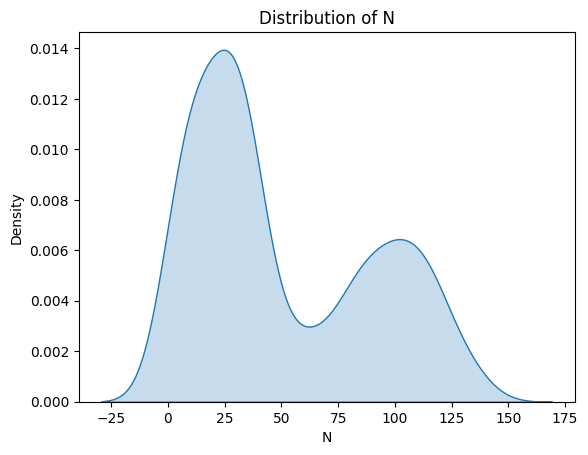

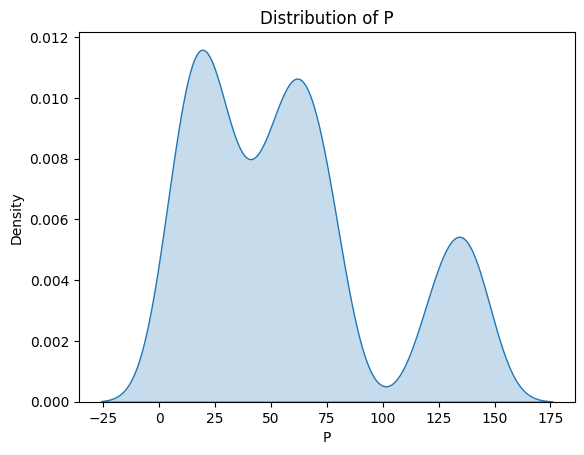

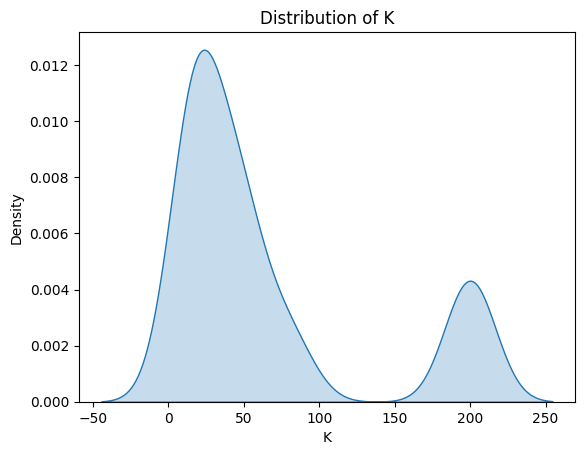

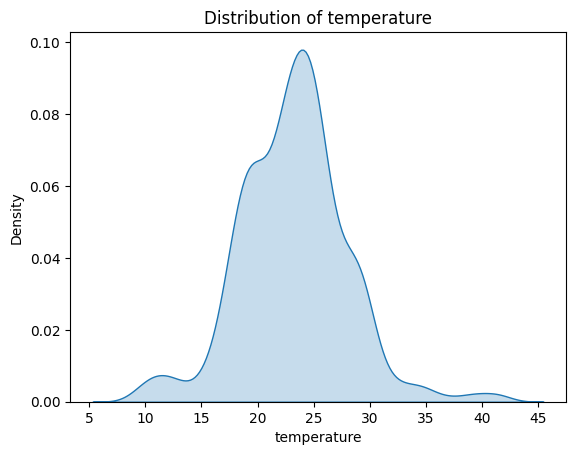

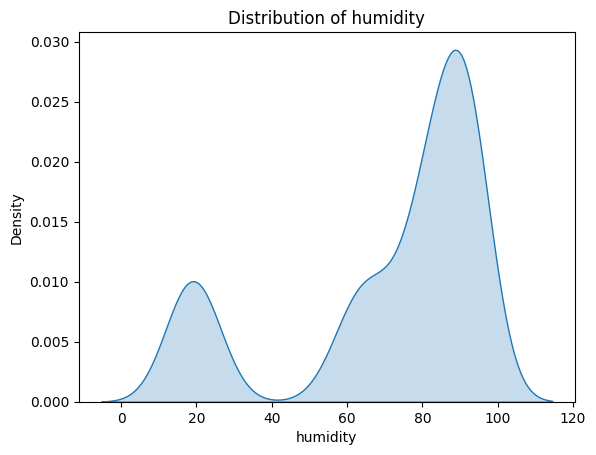

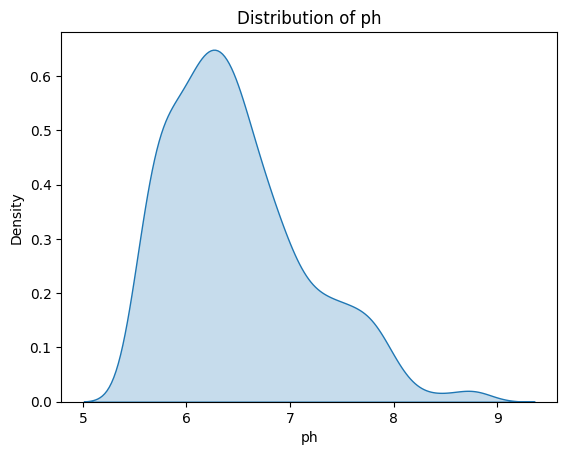

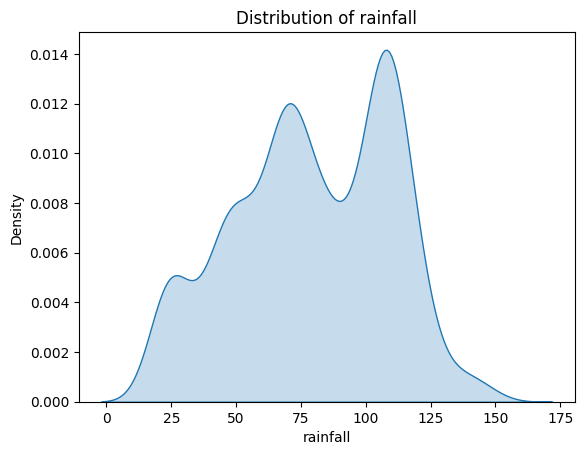

In [18]:
# KDE plots for numerical features
for col in ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']:
    sns.kdeplot(filtered_df[col], shade=True)
    plt.title(f'Distribution of {col}')
    plt.show()

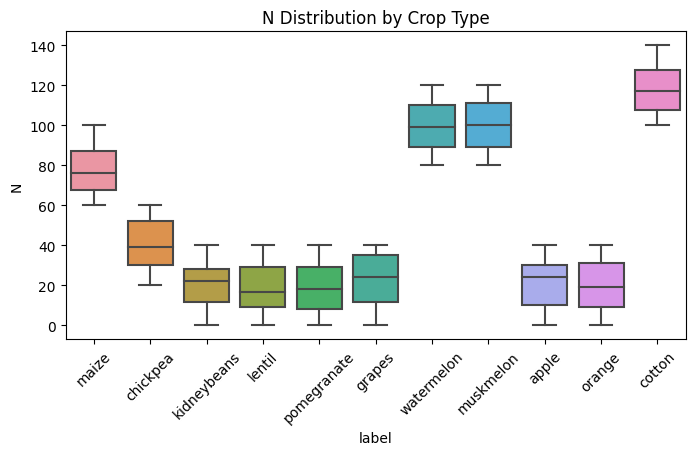

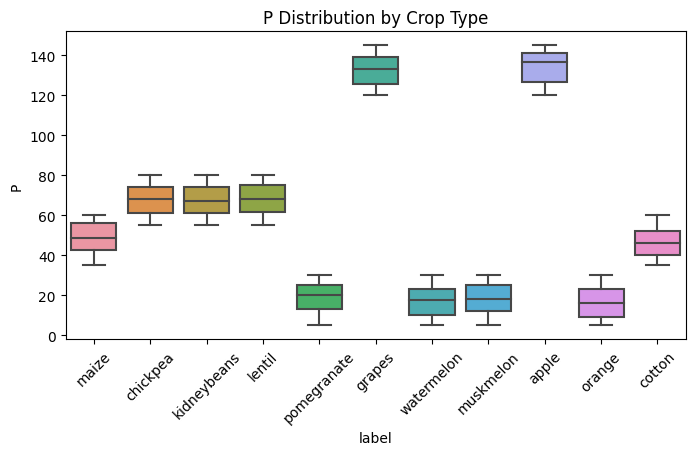

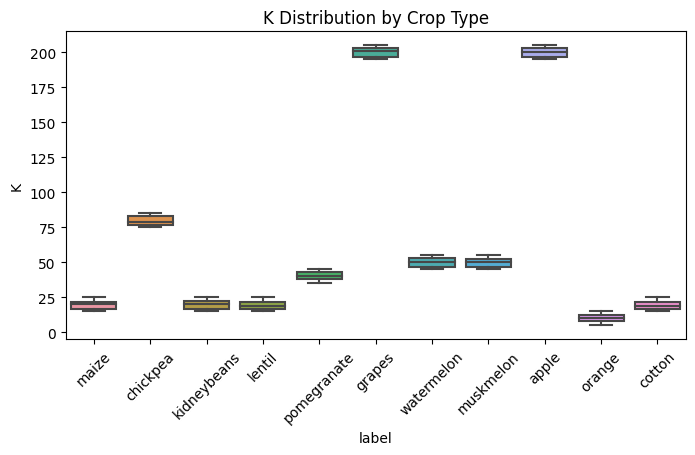

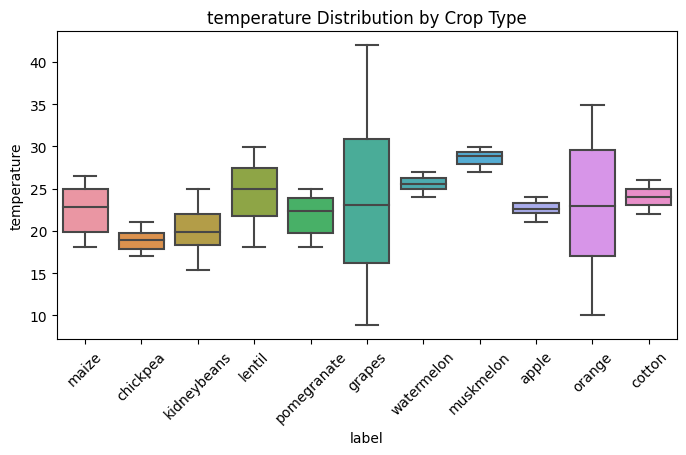

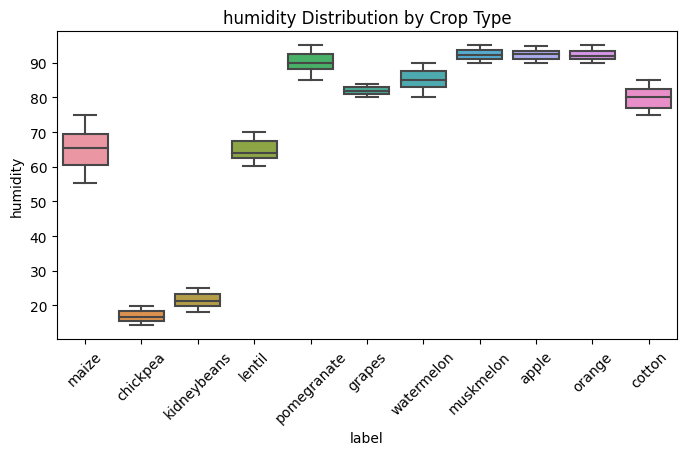

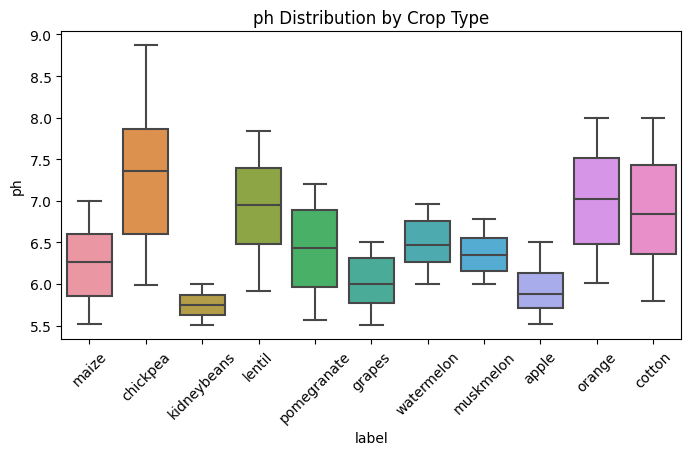

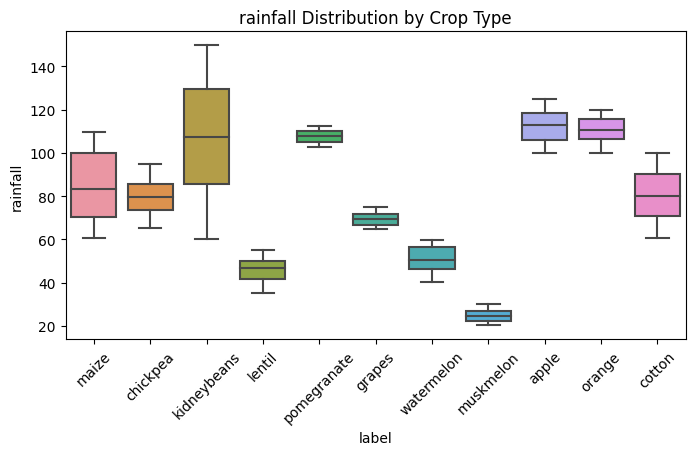

In [19]:
# Boxplots of features grouped by crop
for col in ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='label', y=col, data=filtered_df)
    plt.xticks(rotation=45)
    plt.title(f'{col} Distribution by Crop Type')
    plt.show()

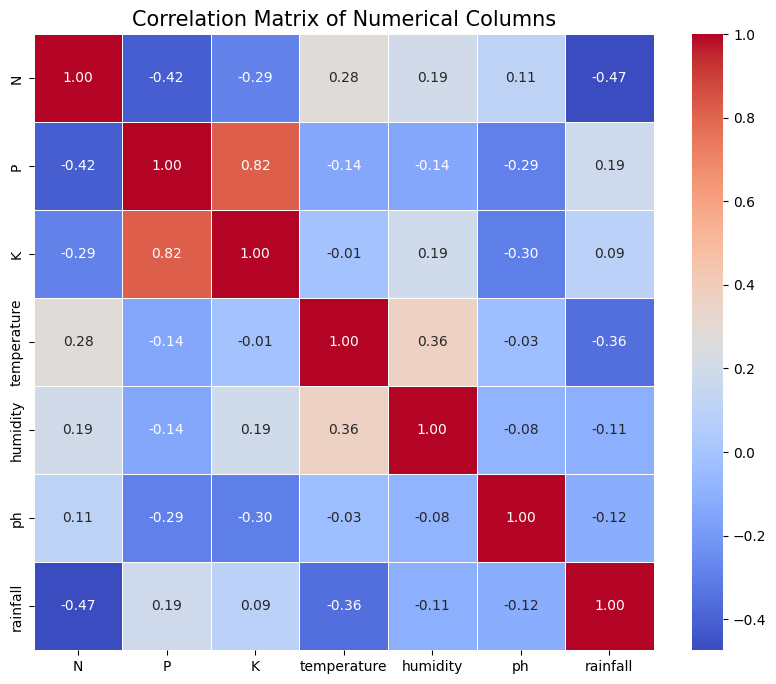

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for numerical columns
correlation_matrix = filtered_df[numerical_cols].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns', fontsize=15)
plt.show()  # Use plt.show() to display in Kaggle


In [20]:
# Define the target variable (y) and the features (X)
X = filtered_df.drop(columns=['label'])  # Drop the target column 'label' to get the features
y = filtered_df['label']  # The target variable is the 'label' column

# Display the first few rows of X and y to verify
print("Features (X):")
print(X.head())

print("\nTarget (y):")
print(y.head())


Features (X):
      N   P   K  temperature   humidity        ph    rainfall
100  71  54  16    22.613600  63.690706  5.749914   87.759539
101  61  44  17    26.100184  71.574769  6.931757  102.266244
102  80  43  16    23.558821  71.593514  6.657965   66.719955
103  73  58  21    19.972160  57.682729  6.596061   60.651715
104  61  38  20    18.478913  62.695039  5.970458   65.438354

Target (y):
100    maize
101    maize
102    maize
103    maize
104    maize
Name: label, dtype: object


In [21]:
X = filtered_df.drop('label', axis=1)  # Features
y = filtered_df['label']  # Target label

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the labels (categorical target variable) using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Fit on training set
y_test_encoded = label_encoder.transform(y_test)  # Transform on test set (no fitting)

# Normalize the features using StandardScaler (or RobustScaler)
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler (to avoid data leakage)
X_test_scaled = scaler.transform(X_test)

# Check the shape of the data
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Test features shape: {X_test_scaled.shape}")
print(f"Training labels shape: {y_train_encoded.shape}")
print(f"Test labels shape: {y_test_encoded.shape}")


Training features shape: (880, 7)
Test features shape: (220, 7)
Training labels shape: (880,)
Test labels shape: (220,)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Test Accuracy on KNN: 0.9954545454545455
Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        22
           8       1.00      0.95      0.97        19
           9       0.95      1.00      0.97        18
          10       1.00      1.00      1.00        14

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg 

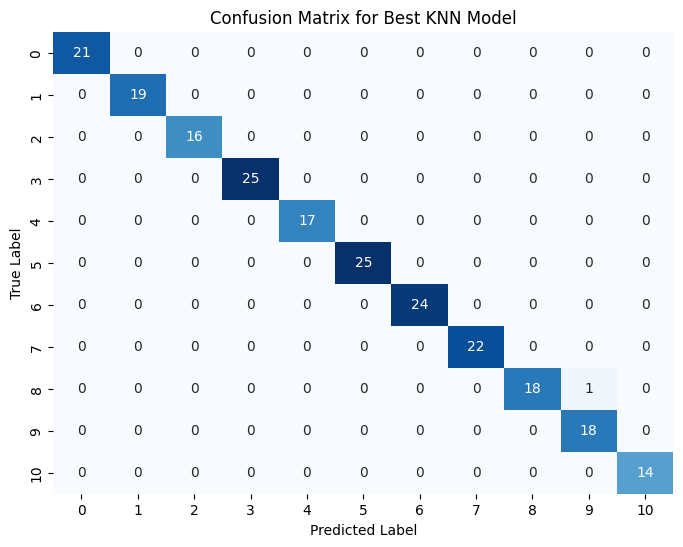

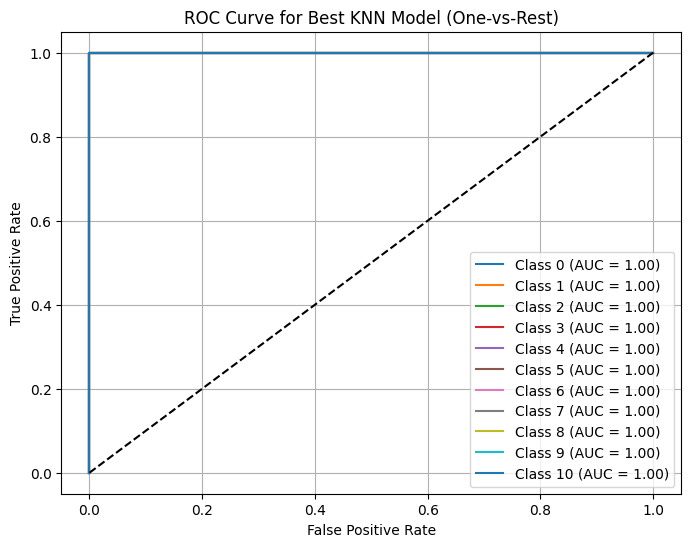

In [26]:

knn_model = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to compute neighbors
    'p': [1, 2]  # Power parameter for Minkowski distance
}


# Perform GridSearch
grid_search_knn = GridSearchCV(
    knn_model,
    param_grid_knn,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search_knn.fit(X_train_scaled, y_train_encoded)

best_knn_model = grid_search_knn.best_estimator_

# Evaluation on Test Set

y_pred_knn = best_knn_model.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)

print(f"Best parameters for KNN: {grid_search_knn.best_params_}")
print(f"Test Accuracy on KNN: {accuracy_knn}")
print(f"Classification Report for KNN:\n{classification_report(y_test_encoded, y_pred_knn)}")


# Confusion Matrix and ROC Curve

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_encoded, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Best KNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict probabilities
y_proba_knn = best_knn_model.predict_proba(X_test_scaled)

# Number of classes
n_classes = len(np.unique(y_train_encoded))

# Binarize the output
y_test_binarized = label_binarize(y_test_encoded, classes=list(range(n_classes)))

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_knn[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_proba_knn[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Best KNN Model (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits

===== Logistic Regression Results =====
Best parameters: {'C': 1, 'solver': 'lbfgs'}
Test Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        18
          10       1.00      1.00      1.00        14

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       

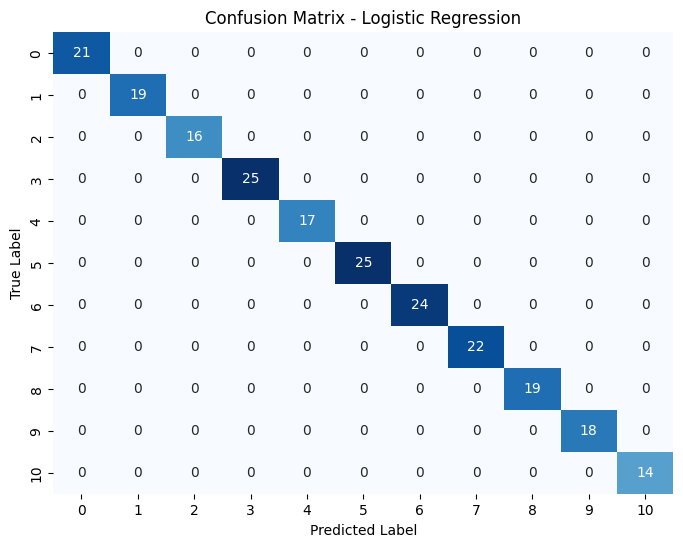

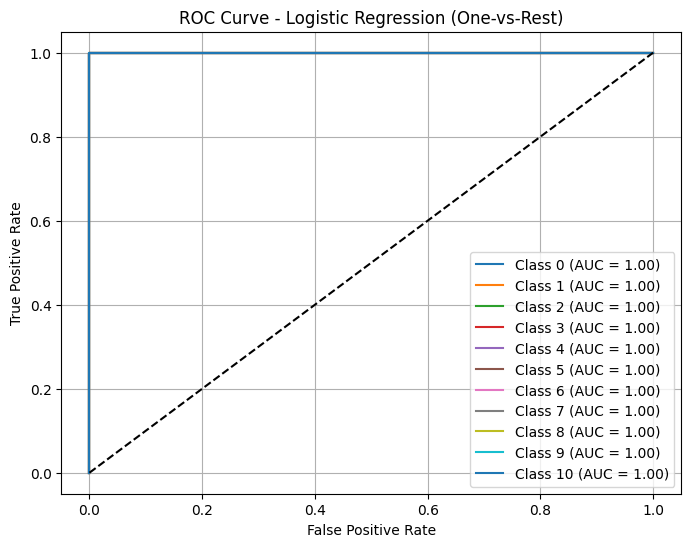

In [27]:
# Define model
lr_model = LogisticRegression(max_iter=1000)

# Define parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Perform GridSearchCV
grid_search_lr = GridSearchCV(
    lr_model, param_grid_lr, cv=5, n_jobs=-1, verbose=1
)
grid_search_lr.fit(X_train_scaled, y_train_encoded)

# Best model
best_lr_model = grid_search_lr.best_estimator_

# Predict on test set
y_pred_lr = best_lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test_encoded, y_pred_lr)

print("\n===== Logistic Regression Results =====")
print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Test Accuracy: {accuracy_lr:.4f}")
print(f"Classification Report:\n{classification_report(y_test_encoded, y_pred_lr)}")

# --- Confusion Matrix ---
cm_lr = confusion_matrix(y_test_encoded, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- ROC Curve ---
y_proba_lr = best_lr_model.predict_proba(X_test_scaled)
n_classes = len(np.unique(y_train_encoded))
y_test_binarized = label_binarize(y_test_encoded, classes=list(range(n_classes)))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_lr[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_proba_lr[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Logistic Regression (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Fitting 5 folds for each of 18 candidates, totalling 90 fits

===== SVM Results =====
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Test Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        18
          10       1.00      1.00      1.00        14

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00    

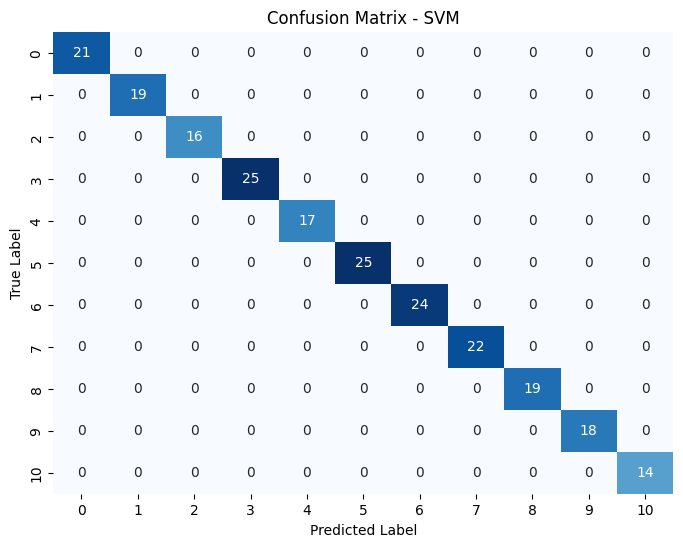

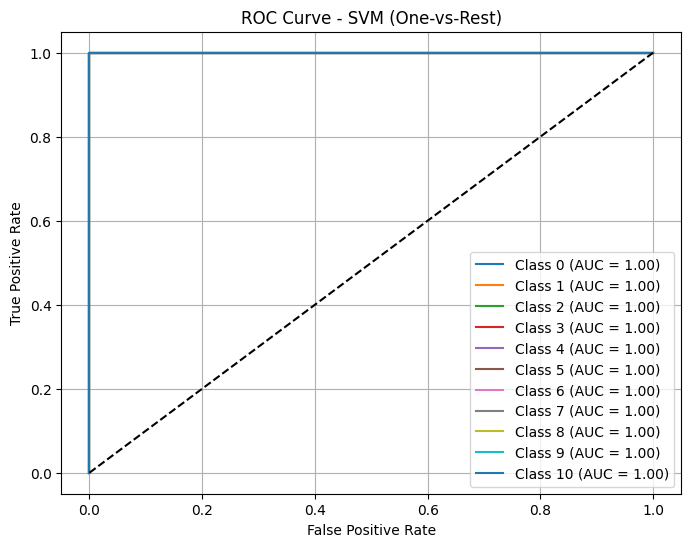

In [28]:

# SVM Model
svm_model = SVC(probability=True)

# Define parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform GridSearchCV
grid_search_svm = GridSearchCV(
    svm_model, param_grid_svm, cv=5, n_jobs=-1, verbose=1
)
grid_search_svm.fit(X_train_scaled, y_train_encoded)

# Best model
best_svm_model = grid_search_svm.best_estimator_

# Predict on test set
y_pred_svm = best_svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)

print("\n===== SVM Results =====")
print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Test Accuracy: {accuracy_svm:.4f}")
print(f"Classification Report:\n{classification_report(y_test_encoded, y_pred_svm)}")

# --- Confusion Matrix ---
cm_svm = confusion_matrix(y_test_encoded, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- ROC Curve ---
y_proba_svm = best_svm_model.predict_proba(X_test_scaled)
n_classes = len(np.unique(y_train_encoded))
y_test_binarized = label_binarize(y_test_encoded, classes=list(range(n_classes)))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_svm[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_proba_svm[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - SVM (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [29]:



# Predict for each model
y_pred_knn = best_knn_model.predict(X_test_scaled)
y_pred_lr = best_lr_model.predict(X_test_scaled)
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Predict probabilities
y_proba_knn = best_knn_model.predict_proba(X_test_scaled)
y_proba_lr = best_lr_model.predict_proba(X_test_scaled)
y_proba_svm = best_svm_model.predict_proba(X_test_scaled)

# Binarize true labels
n_classes = len(np.unique(y_train_encoded))
y_test_binarized = label_binarize(y_test_encoded, classes=list(range(n_classes)))


# Accuracy
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)
accuracy_lr = accuracy_score(y_test_encoded, y_pred_lr)
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)

# Average ROC-AUC (macro average)
roc_auc_knn = roc_auc_score(y_test_binarized, y_proba_knn, average="macro")
roc_auc_lr = roc_auc_score(y_test_binarized, y_proba_lr, average="macro")
roc_auc_svm = roc_auc_score(y_test_binarized, y_proba_svm, average="macro")



comparison_df = pd.DataFrame({
    'Model': ['KNN (GridSearch)', 'Logistic Regression (GridSearch)', 'SVM (GridSearch)'],
    'Test Accuracy': [accuracy_knn, accuracy_lr, accuracy_svm],
    'Average ROC-AUC': [roc_auc_knn, roc_auc_lr, roc_auc_svm]
})

# Sort by best accuracy
comparison_df = comparison_df.sort_values(by='Test Accuracy', ascending=False)

# Display the table
print("\n===== Final Comparison Table =====")
print(comparison_df.to_markdown(index=False, tablefmt="fancy_grid"))



===== Final Comparison Table =====
╒══════════════════════════════════╤═════════════════╤═══════════════════╕
│ Model                            │   Test Accuracy │   Average ROC-AUC │
╞══════════════════════════════════╪═════════════════╪═══════════════════╡
│ Logistic Regression (GridSearch) │        1        │                 1 │
├──────────────────────────────────┼─────────────────┼───────────────────┤
│ SVM (GridSearch)                 │        1        │                 1 │
├──────────────────────────────────┼─────────────────┼───────────────────┤
│ KNN (GridSearch)                 │        0.995455 │                 1 │
╘══════════════════════════════════╧═════════════════╧═══════════════════╛


We can choose between logistic regression and svm since they gave excellent results

->Logistic regression

In [53]:
random_input = np.array([[5, 10, 2, 25, 0, 0, 0]])  # Replace with your actual feature values

# Scale the random input using the fitted scaler
random_input_scaled = scaler.transform(random_input)

# Predict the crop
predicted_crop = best_lr_model.predict(random_input_scaled)

# Get the original label (you might want to reverse the encoding)
predicted_crop_label = label_encoder.inverse_transform(predicted_crop)

print(f"Predicted Crop: {predicted_crop_label}")


Predicted Crop: ['kidneybeans']


In [54]:


joblib.dump(best_lr_model, 'best_logistic_regression_model.pkl')

print("Model saved successfully!")


Model saved successfully!
